# Estimate forcing for historical and SSPs

In [147]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import my_functions as f
importlib.reload(f) # needed to load new changes in my_functions
import warnings
warnings.filterwarnings('ignore')

saveforcingdata = True # create one file for each model/exp/member, combine them later if needed
saveforcingfigure = True
save_tasdiff = True # to be used in figure for models where we have transient fixed-SST forcing


## Choose model and compute forcing for all members

In [167]:
model = 'MIROC6'

In [168]:
print('abrupt-4xCO2 members used to estimate parameters', f.find_members(model, 'abrupt-4xCO2'))
for exp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    modeldir = '../Processed_data/Global_annual_anomalies/'
    if os.path.isdir(modeldir + model + '/' + exp) == False:
            continue
    print(exp, 'members', f.find_members(model, exp))

abrupt-4xCO2 members used to estimate parameters ['r1i1p1f1']
ssp126 members ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
ssp245 members ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
ssp370 members ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
ssp585 members ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']


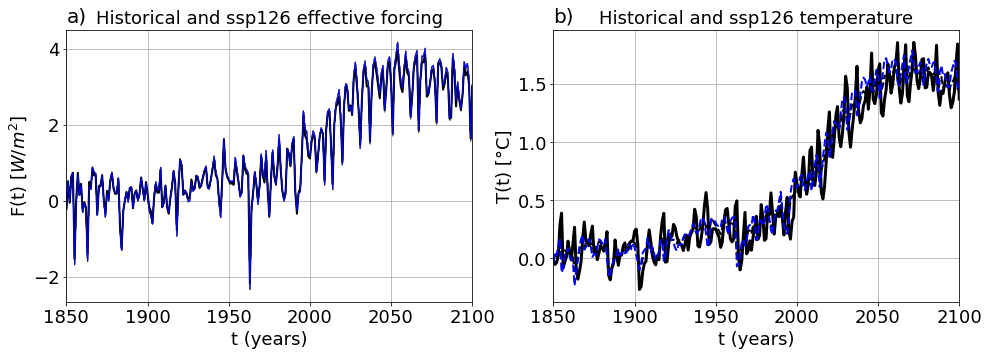

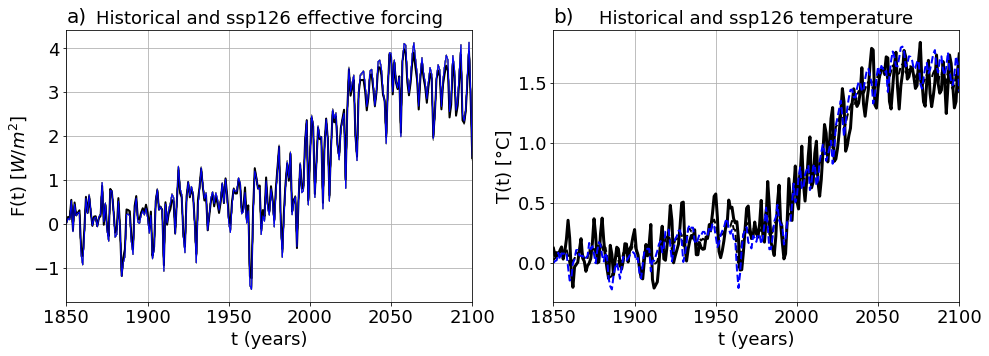

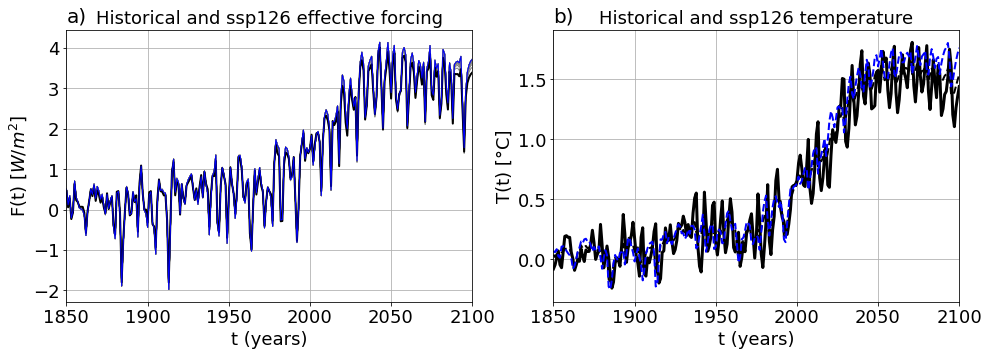

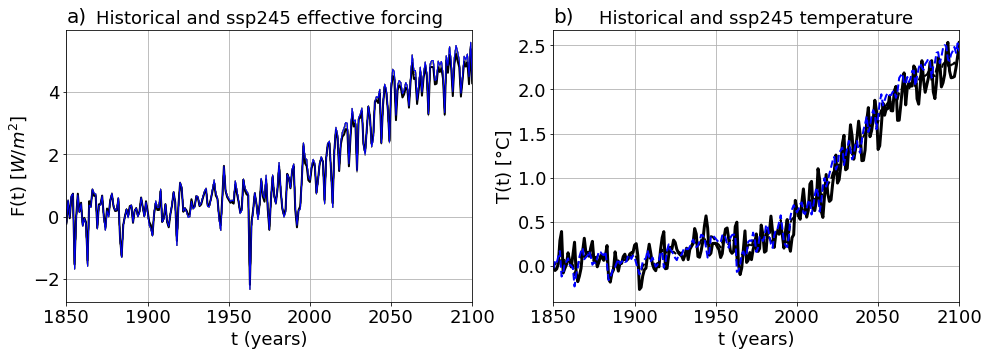

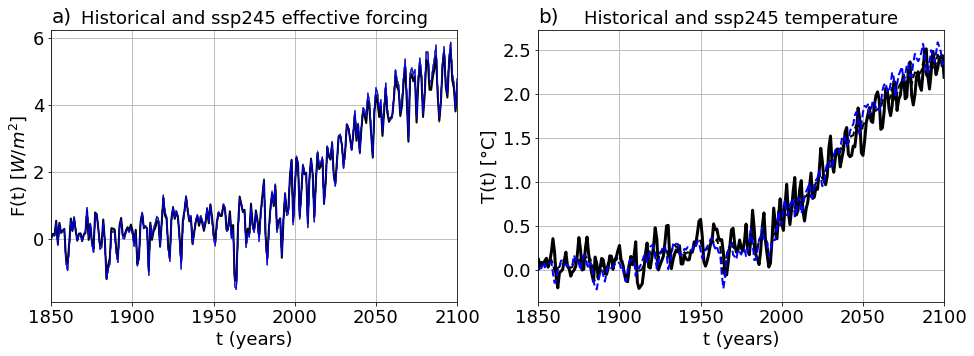

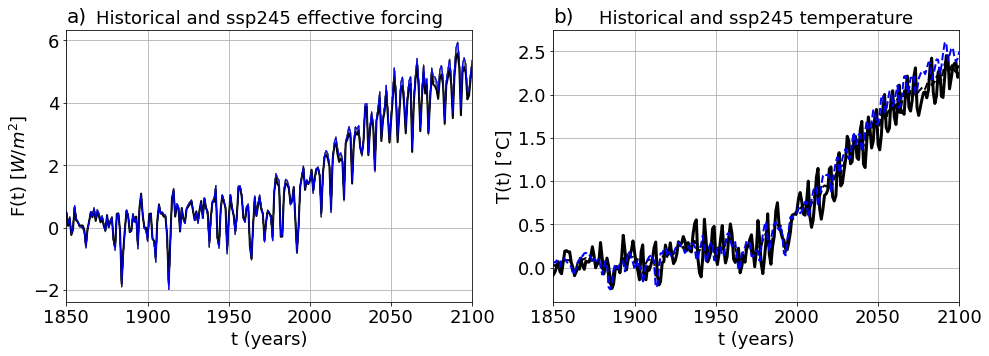

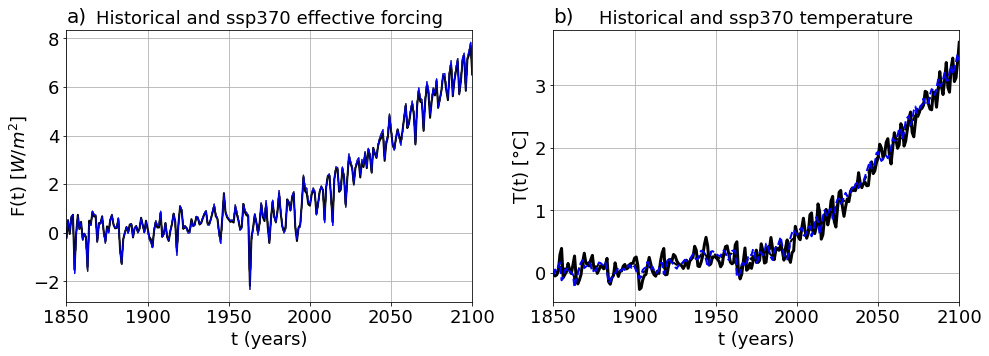

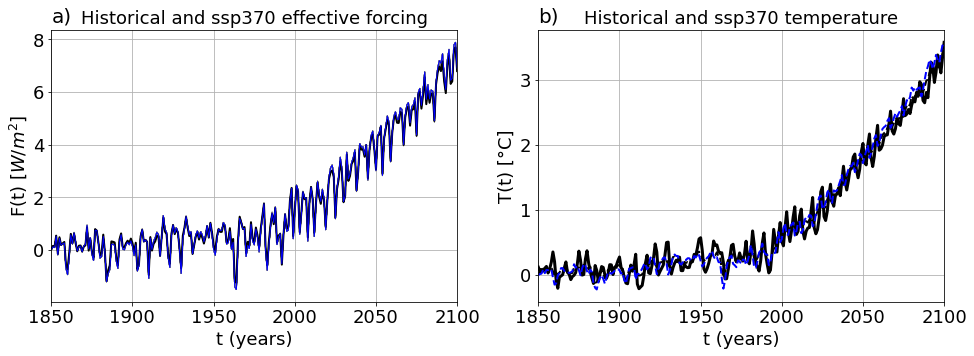

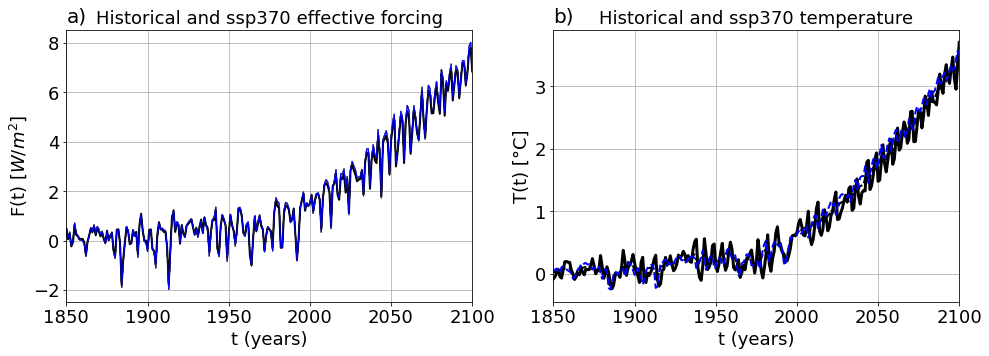

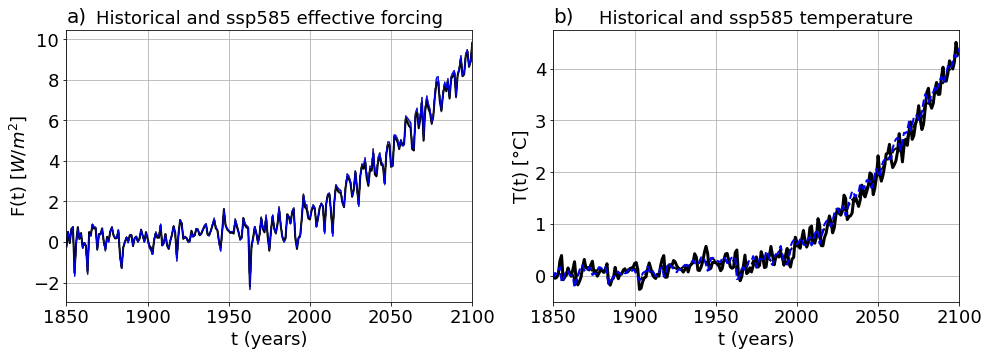

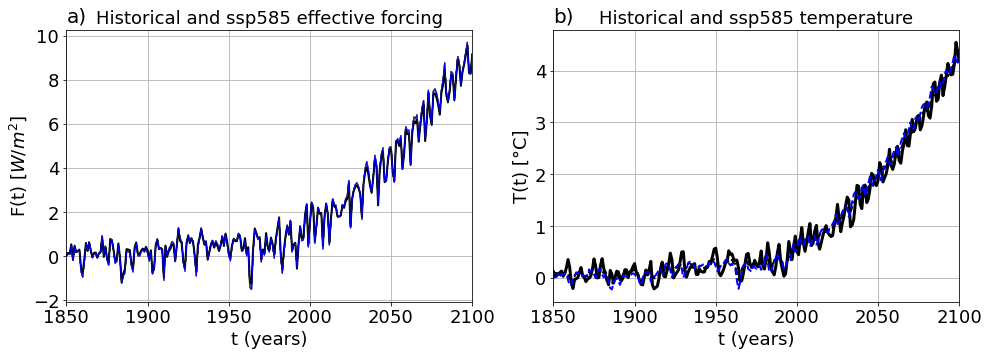

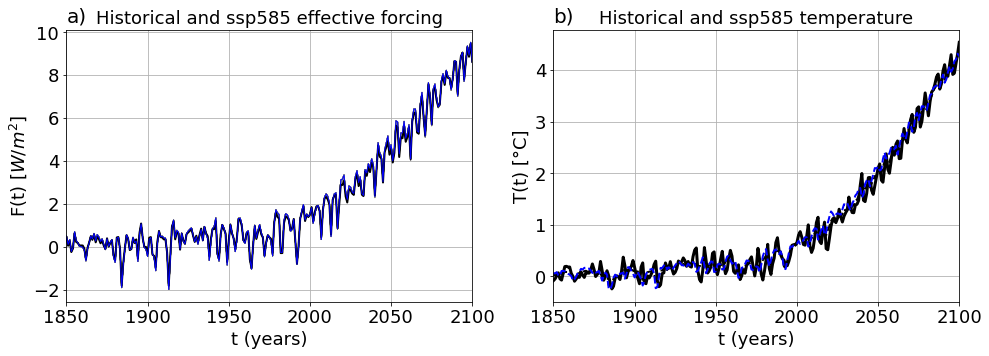

In [169]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']
importlib.reload(f)
for exp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
#for exp in ['ssp585']:
    # if ssp anom directory does not exist, then move on to next exp:
    modeldir = '../Processed_data/Global_annual_anomalies/'
    if os.path.isdir(modeldir + model + '/' + exp) == False:
        continue
    members = f.find_members(model, exp)
    
    for member in members:
    #for member in ['r1i1p1f1']:

        # load historical and ssp data, and combine the time series
        historical_filename = model + '_historical_' + member + '_anomalies.txt'
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, 'historical', historical_filename)
        if os.path.isfile(file) == False:
            print('corresponding historical member is not available for', exp, member)
            continue
        historical = f.load_anom(model, 'historical', member)
        ssp = f.load_anom(model, exp, member)
        data = pd.concat([historical, ssp], ignore_index = True)

        N = data['rsdt'] - data['rsut'] - data['rlut']
        if model == 'AWI-CM-1-1-MR':
            data['tas'][0]=0 # set an approximate value since it does not exist for some reason...
        years = np.arange(1850, 1850+len(data));
        #variables = list(data)

        #f.plot_allvar_preloaded(years, data, model, member, plot_title = model + ' historical and ' + exp + ' ' + member)
        #f.plot_tasandN(years, data['tas'], N, plot_title = model + ' historical and ' + exp + ' ' + member)

        F = f.forcing_F13(data['tas'], N, model)

        # load parameters needed to make new forcing estimate:
        filename = 'best_estimated_parameters_allmembers.txt'
        #filename = 'best_estimated_parameters.txt'

        parameter_table = pd.read_table('../Estimates/' + filename,index_col=0)
        #print(parameter_table.loc[model])
        #parameter_table2 = pd.read_table('../Estimates/best_estimated_parameters.txt',index_col=0)
        #print(parameter_table2.loc[model])
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']

        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        t = np.arange(0,len(F))
        #tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
        #Tn = amplitudes*tas_pred

        # Compute new estimate of forcing
        it = 20  # number of iterations
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                        timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

        #f.plot_components(years, Tn, taulist)

        f.forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], sspexp = exp, model = model)

        if saveforcingfigure == True:
            plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
        #plt.close()

        if saveforcingdata == True:
            # create model directory if it does not already exist
            if os.path.isdir('../Estimates/Transient_forcing_estimates/' + model) == False:
                os.makedirs('../Estimates/Transient_forcing_estimates/' + model)
            index = pd.Index(years, name='Year')

            # save files
            df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
            modelfilename = model + '_historicaland_' + exp + '_' + member + '_F13_ERF.txt'
            df_F13.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
            modelfilename = model + '_historicaland_' + exp + '_' + member + '_ERF.txt'
            df_F.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

        if save_tasdiff == True:
            # save difference between linear response to new forcing and coupled model tas
            tas_diff = Tiarray[:,-1] - data['tas']
            index = pd.Index(years, name='Year')
            df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
            tas_filename = model + '_historicaland_' + exp + '_' + member + '_tas_diff.txt'
            df_tas.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + tas_filename, sep='\t')

    
    